In [169]:

import os
import pandas as pd
import numpy as np
import seaborn  as sns
from plotnine import *
import random
import warnings
import matplotlib.pyplot as plt
from fpppy.utils import plot_series

from IPython.display import Image

from functools import partial

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mqloss

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals
from statsforecast.models import (
    WindowAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 5: The forecaster's toolbox


## 5.2. Some simple forecasting methods 

In practice, simple methods are only useful a references. 

### Mean method 

Forecasts of all future values ($T + h$) are set to be the average of all previous values. 

$$
\hat{y}_{T+h|T} = \bar{y} = \frac{(y_1 + ... + y_T)}{T}
$$

### Naïve method

Each forecast is set to the previous value. 

$$
\hat{y}_{T+h|T} = y_T
$$

### Seasonal naïve method 

Each forecast is set to its value in the prior period of last season. For example, a prediction for a Monday on weekly data would be the value on the prior Monday. Mathematically, the value for the next prediction given all previous $T$ observations, $T + h|T$, is the value from the same $m$ season from the last period, which is defined as the number of complete seasons that have elapsed ($m(k+1)$, where the integer of $k=(k-1)/m$ and is taken). 

$$
\hat{y}_{T+h|T} = y_{T+h - m(k+1)}
$$

### Drift method

Forecasts are set to the average change observed over the entire course of the time series. 

$$
\hat{y}_{T+h|T}  = y_{T+h} + h \Big(\frac{y_t - y_1}{T -1}\Big)
$$

/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2974823842.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2974823842.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


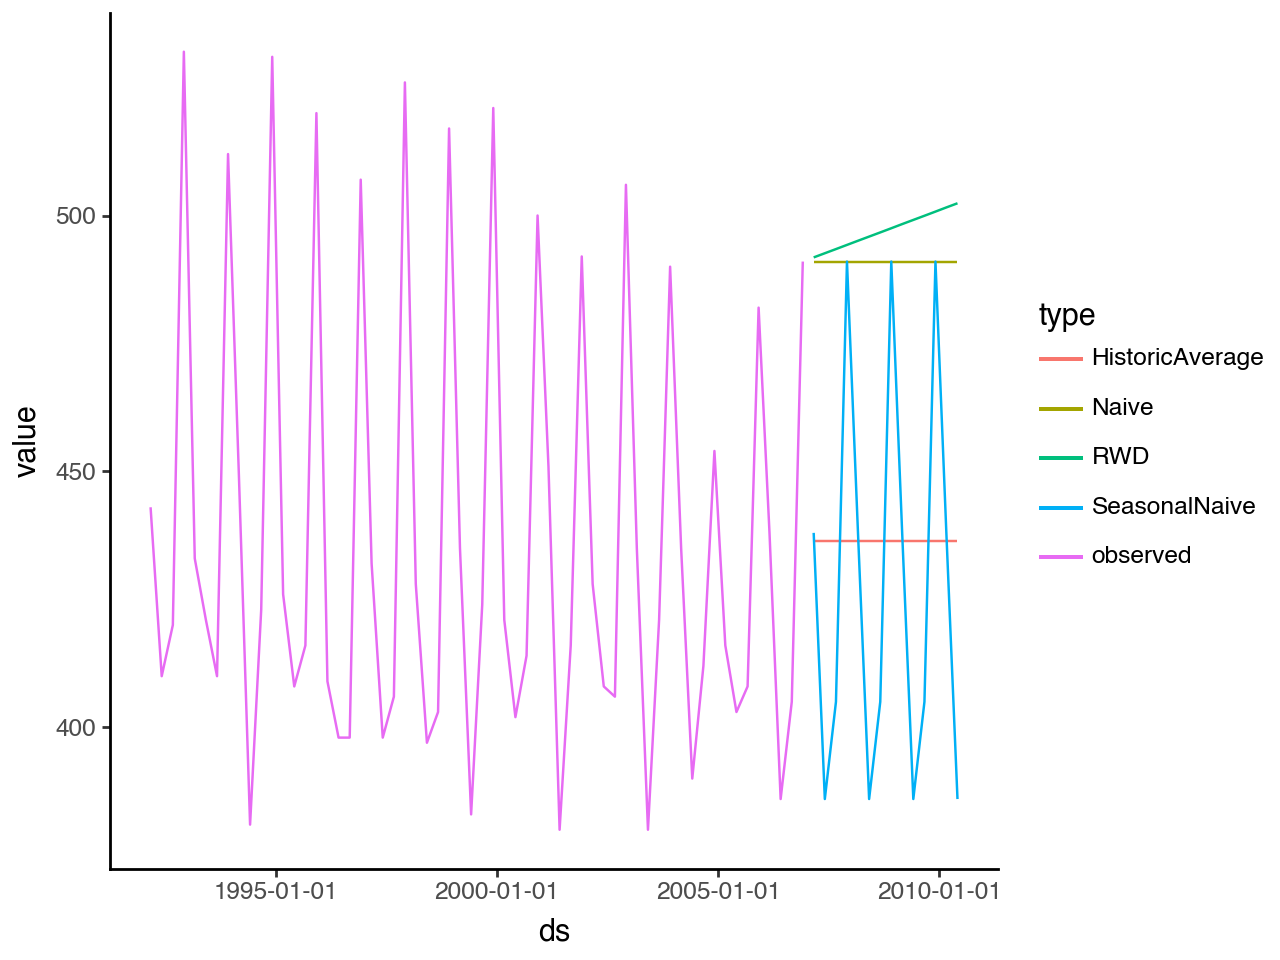

In [33]:
df_aus_beer = pd.read_csv('data/raw/aus_production_formatted.csv')

df_aus_beer = df_aus_beer.query("unique_id == 'Beer' and ds >= '1992-01-01'")
df_train = df_aus_beer[:-14]
df_test = df_aus_beer[-14:]

avg_method = HistoricAverage()
naive_method = Naive()
seasonal_naive_method = SeasonalNaive(4)
drift_method = RandomWalkWithDrift()


sf = StatsForecast(
    models=[avg_method, naive_method, seasonal_naive_method, drift_method], 
    freq=pd.offsets.QuarterBegin(1)
)
sf.fit(df_train)

df_forecast = sf.predict(h=14)
df_forecast["y"] = df_test["y"].values

df_train['type'] = 'observed'
df_train.rename(columns={"y": "value"}, inplace=True)

df_forecast = pd.melt(frame=df_forecast, id_vars=['unique_id', 'ds'], var_name='type', 
                      value_name='value')
df_forecast = df_forecast.loc[~df_forecast['type'].isin([np.nan, 'y'])]

df_merged = pd.concat(objs=[df_train, df_forecast], ignore_index=True)
df_merged['ds'] = pd.to_datetime(df_merged['ds'])

(ggplot(data=df_merged, mapping=aes(x='ds', y='value', group='type', color='type')) + 
 geom_line() + 
 theme_classic())

## 5.3. Fitted values and residuals 

Fitted values are based on all previous values, whereas forecasts can be based on future values. 
Innovation residuals are simply residuals based on transformed variables. 

To obtain fitted values and residuals, set `fitted=True` in `StatsForecast()` 

In [34]:
train = df_aus_beer[:-14]
test = df_aus_beer[-14:]

mean_method = HistoricAverage()
sf = StatsForecast(models=[mean_method], freq="Q")
sf.forecast(h=14, df=train, fitted=True)
fitted_values = sf.forecast_fitted_values()
train["fitted"] = fitted_values["HistoricAverage"].values
train["resid"] = train["y"] - train["fitted"]
train["innov"] = train["y"] - train["fitted"]
train.head()

/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2110831483.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/2110831483.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,unique_id,ds,y,fitted,resid,innov
144,Beer,1992-03-01,443.0,436.45,6.55,6.55
145,Beer,1992-06-01,410.0,436.45,-26.45,-26.45
146,Beer,1992-09-01,420.0,436.45,-16.45,-16.45
147,Beer,1992-12-01,532.0,436.45,95.55,95.55
148,Beer,1993-03-01,433.0,436.45,-3.45,-3.45


## 5.4. Residual diagnostics

Good forecasting models have residuals that are 

1. Uncorrelated. Correlated residuals suggests there is signal that can be modelled. 
2. Zero mean. Otherwise, forecasts will be biased. 

Importantly, these conditions are not sufficient for creating a good model. Bias is easier to solve than correlatednes (i.e., if biased with mean $m$, $m$ can simply be added to all forecasts). 

The following conditions are useful for constructing reliable prediction intervals: 

3. Constant variance
4. Normally distributed 

Importantly, a model that does not satisfy properties 3) and 4) cannot necessarily be improved. 

### Portmanteau tests for autocorrelation

Examining autocorrelation individually invites Type I errors. To solve this problem, we consider whether the first $l$ autocorrelations differ from a white noice process. This is the **portmanteau test**. There are several statistics to run this test such as the **Box-Piece test** 

$$
Q = T \sum^\ell_{k=1} r^2k_k, 
$$

where $\ell$ is the maximum lag being considered, $T$ is the number of observations. Recommend using $\ell=10$ for non-seasonal data and $\ell=2m$ for seasonal data. That said, test is not useful for large $\ell$ and $\ell$ should be capped at T/5. 

Another method is the **Ljung-Box** test

$$
Q^\ast = T(T+2) \sum^\ell_{k=1} (T-k)^{-1} r^2_k
$$

Q (or $Q^ast$) have a $\chi^2$ distribution when they become too large. 

In the example below, there are considerable autocorrelations among the residuals. 

In [37]:
resid_test = acorr_ljungbox(x=train['resid'].dropna(), boxpierce=True)
resid_test.round(2)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.91,0.34,0.86,0.35
2,28.67,0.00,26.84,0.00
3,29.18,0.00,27.31,0.00
4,78.04,0.00,71.44,0.00
5,78.58,0.00,71.91,0.00
6,105.42,0.00,95.29,0.00
7,106.07,0.00,95.84,0.00
8,154.43,0.00,136.41,0.00
9,155.27,0.00,137.10,0.00
10,180.30,0.00,157.28,0.00


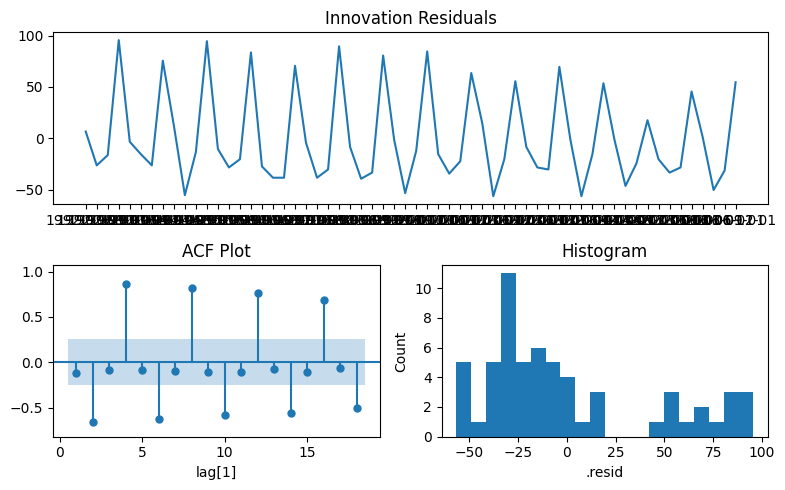

In [52]:
def plot_diagnostics(data):
    fig = plt.figure(figsize=(8, 5))

    ax1 = fig.add_subplot(2, 2, (1, 2))
    ax1.plot(data['ds'], data["resid"])
    ax1.set_title("Innovation Residuals")

    ax2 = fig.add_subplot(2, 2, 3)
    plot_acf(data["resid"].dropna(), ax=ax2, zero=False,
      bartlett_confint=False, auto_ylims=True)
    ax2.set_title("ACF Plot")
    ax2.set_xlabel('lag[1]')

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.hist(data["resid"], bins=20)
    ax3.set_title("Histogram")
    ax3.set_xlabel(".resid")
    ax3.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


plot_diagnostics(train)


## 5.5 Distributional forecasts and prediction intervals 
### One-step prediction intervals
For one-step forecasts, prediction intervals can be estimated using the standard deviation of the residuals: 

$$
\hat{\sigma} = \sqrt{\frac{1}{T - K - M}\sum^T_{t=1e^2_t}}, 
$$

where K is the number of parameters and M is the number of missing values (e.g., M=1 for naïve method because there is no value before the first one). 

### Multi-step prediction intervals

A more advanced calculation is needed to $\sigma_h$ for multi-step prediction intervals. Importantly, the following calculations assume uncorrelated residuals. 

### Benchmark methods 

The `statsforecast` package provides convenient computation of multi-step prediction intervals 

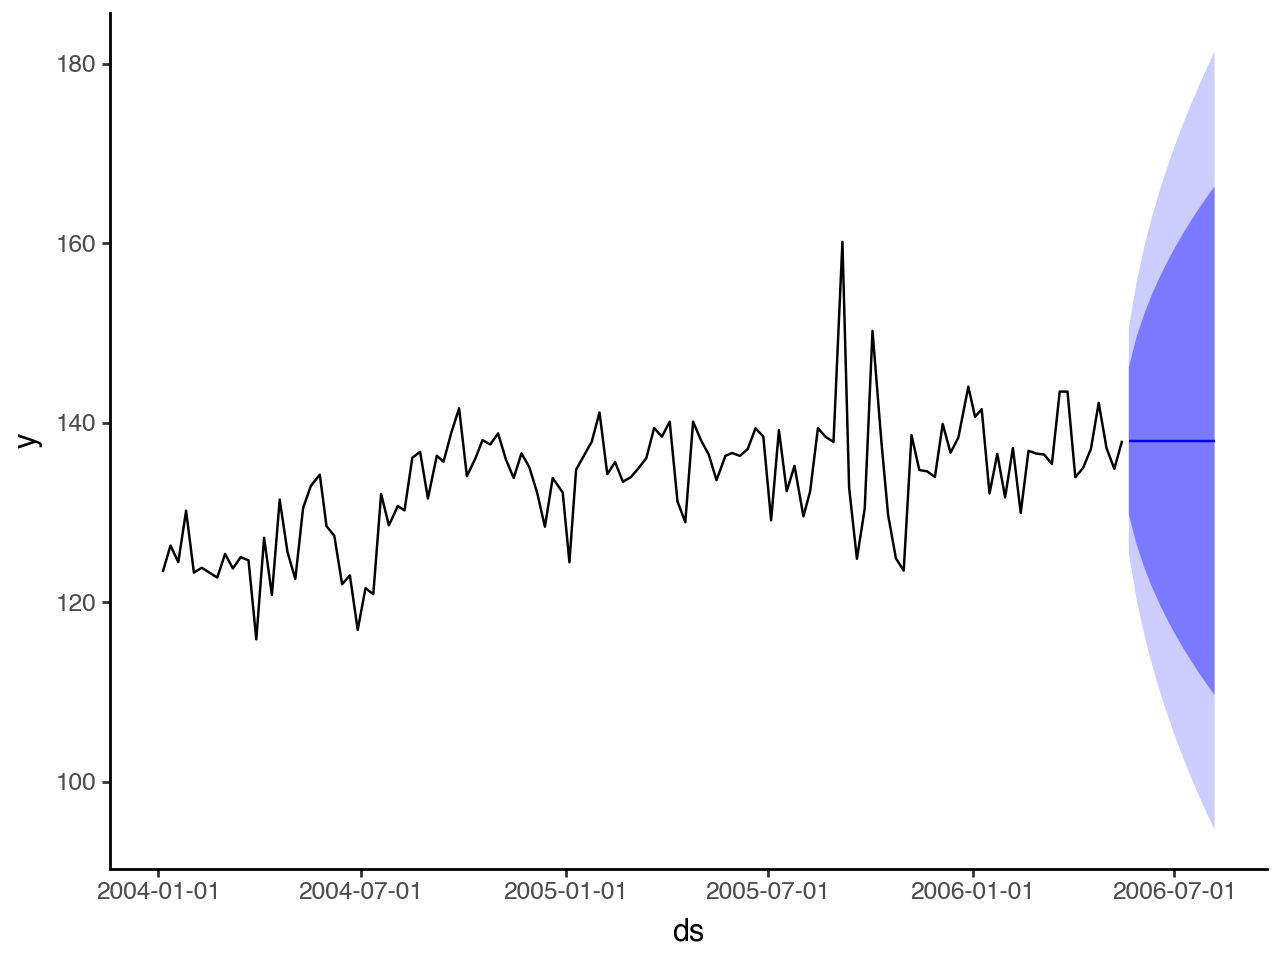

In [114]:
# Run naive forecasting method on Toronto gas prices 
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')
df_toronto.reset_index(inplace=True)

# rename for formatting
df_toronto.rename(columns={"Date": "ds", 
                           "price_2025": "y", 
                           "city": "unique_id"}, inplace=True)

cols = ['ds', 'y', 'unique_id']
df_train = df_toronto[cols][:-1000]
df_test = df_toronto[cols][-1000:]

naive_method = Naive()

sf = StatsForecast(
    models=[naive_method], 
    freq='W')

sf.fit(df_train)

df_forecast = sf.forecast(df=df_train, h=12, level=[80, 95])  # NOTE: forecast for next 3 months (12 weeks)

(ggplot(data=df_train.loc[df_train['ds'].gt('2004')], mapping=aes(x='ds', y='y')) + 
 geom_line() + 
 geom_line(inherit_aes=False, data=df_forecast, 
           mapping=aes(x='ds', y='Naive'), color='blue') + 
 geom_ribbon(inherit_aes=False, data=df_forecast, 
             mapping=aes(x='ds', ymin='Naive-lo-95', ymax='Naive-hi-95'), fill='blue', alpha=0.2) + 
 geom_ribbon(inherit_aes=False, data=df_forecast, 
             mapping=aes(x='ds', ymin='Naive-lo-80', ymax='Naive-hi-80'), fill='blue', alpha=0.4) + 
 theme_classic())

### Bootstrapping 

Prediction intervals are created by simulating several thousand possible predictions and then taking a certain percentage of the predictions. Importantly, prediction intervals may not be symmetric because normality is not assumed in this process. 


/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_22642/3381045528.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


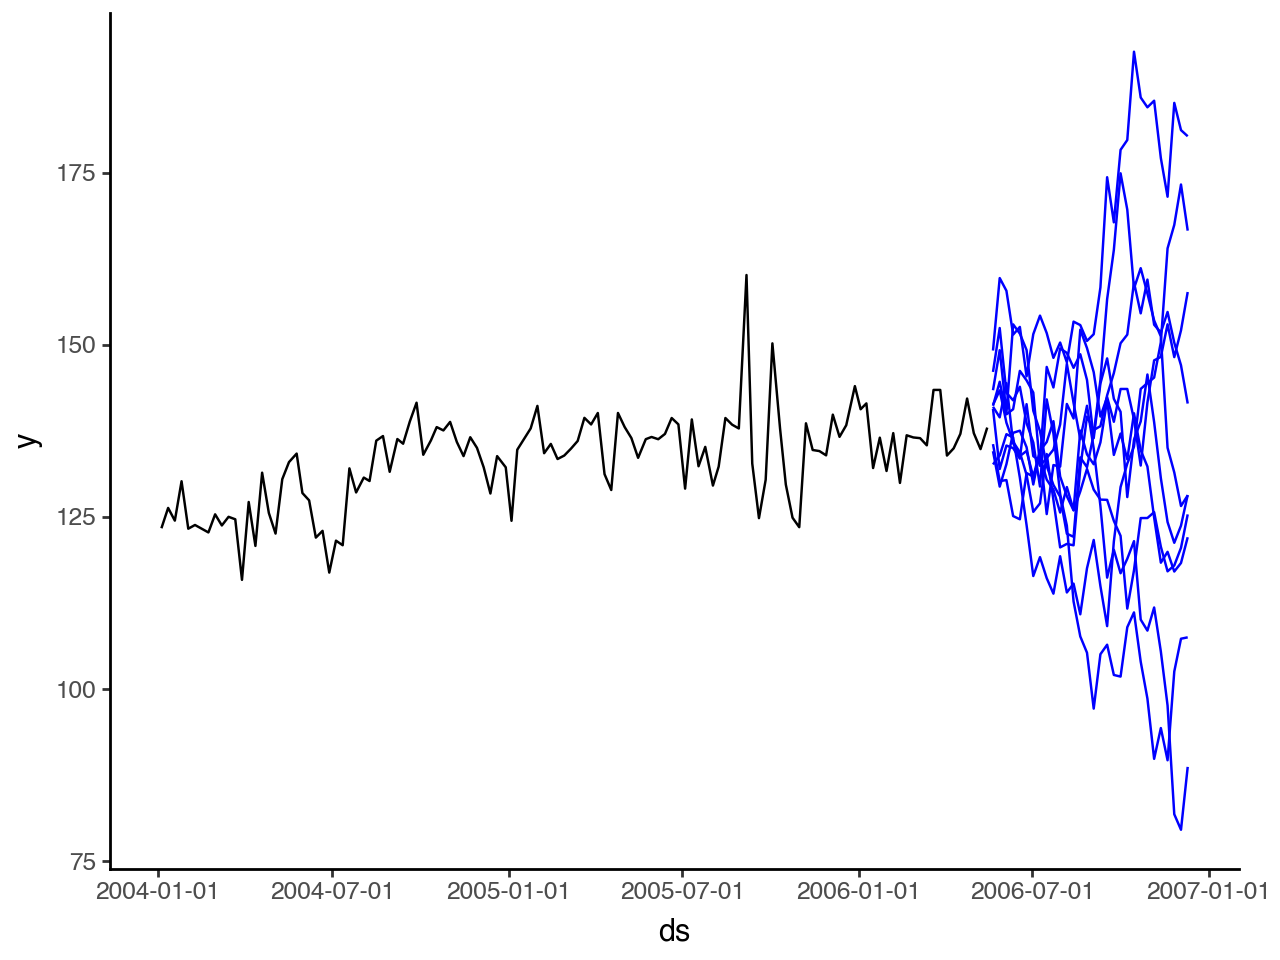

In [145]:
# bootstrapped prediction intervals
fc = sf.forecast(df=df_train, h=30, fitted=True)
fitted = sf.forecast_fitted_values()
errors = fitted['y']-fitted['Naive']
errors = errors[1:].to_list() # first value is NaN
last_obs = df_train['y'].iloc[-1]

num_sims = 5000 
sim = np.zeros((30,num_sims))

for j in range(num_sims): 
    e = random.sample(errors, 1).pop()
    yhat = last_obs+e 

    sim[0,j] = yhat

    for i in range(1,30): 
        e = random.sample(errors, 1).pop()
        sim[i,j] = sim[i-1,j]+e  # take the last prediction and add randomly sampled error 

df_sim = pd.DataFrame(sim)
df_sim.columns = [f"sim_{i}" for i in range(num_sims)] 

n_rows = len(df_sim)

# generate weekly dates starting from 2006-05-21
df_sim['date'] = pd.date_range(start='2006-05-21', periods=n_rows, freq='W')

# add in 10 predictions for next 30 observations 
df_sim_10 = df_sim.iloc[ : ,: 10]
df_sim_10['ds'] = df_sim['date'] 

df_long = df_sim_10.melt(
    id_vars='ds', 
    var_name='series', 
    value_name='value')

(ggplot(data=df_train.loc[df_train['ds'].gt('2004')], mapping=aes(x='ds', y='y')) + 
 geom_line() + 
 geom_line(inherit_aes=False, data=df_long, 
           mapping=aes(x='ds', y='value', group='series'), color='blue') + 
 theme_classic())

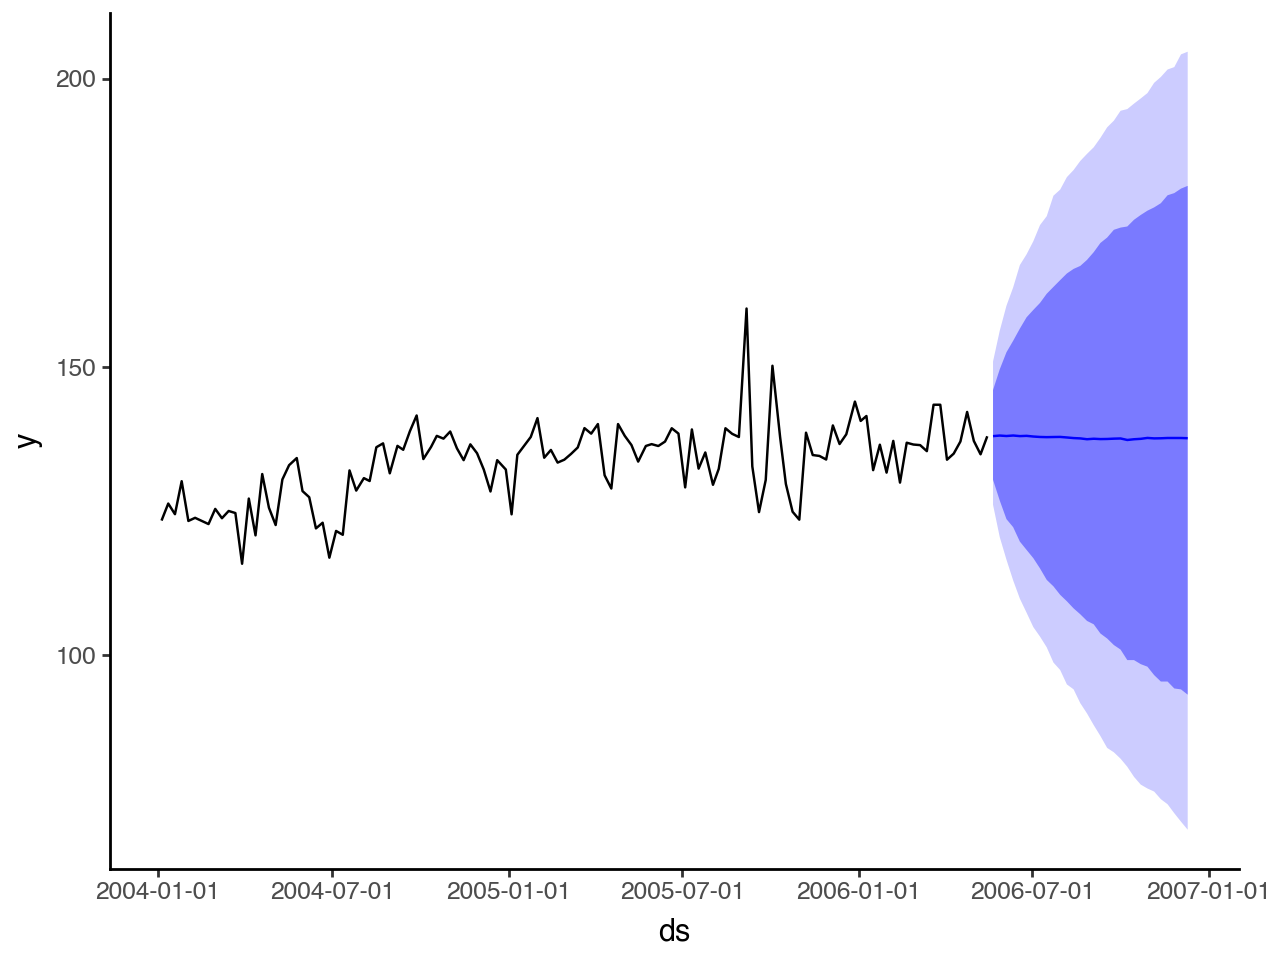

In [147]:
# Plot bootstrapped prediction intervals 
df_sim['bootstrap'] = df_sim.drop(['date'], axis=1).mean(axis=1)

df_sim['bootstrap-lo-80'] = df_sim.drop(['date'], axis=1).quantile(0.1, axis=1)
df_sim['bootstrap-hi-80'] = df_sim.drop(['date'], axis=1).quantile(0.9, axis=1)
df_sim['bootstrap-lo-95'] = df_sim.drop(['date'], axis=1).quantile(0.025, axis=1)
df_sim['bootstrap-hi-95'] = df_sim.drop(['date'], axis=1).quantile(0.975, axis=1)


(ggplot(data=df_train.loc[df_train['ds'].gt('2004')], mapping=aes(x='ds', y='y')) + 
 geom_line() + 
 geom_line(inherit_aes=False, data=df_sim, 
           mapping=aes(x='date', y='bootstrap'), color='blue') + 
 geom_ribbon(inherit_aes=False, data=df_sim, 
             mapping=aes(x='date', ymin='bootstrap-lo-95', ymax='bootstrap-hi-95'), fill='blue', alpha=0.2) + 
 geom_ribbon(inherit_aes=False, data=df_sim, 
             mapping=aes(x='date', ymin='bootstrap-lo-80', ymax='bootstrap-hi-80'), fill='blue', alpha=0.4) + 

 theme_classic())

### Conformal prediction for distribution-free prediction intervals 

Conformal predictions make no distributional assumptions. This appears to be a more advanced topic. Big picture, a central assumption is **exchangeability**: distribution of past residuals is representative of distribution of future residuals. 

## 5.6. Forecasting using transformations 

When back-transforming to the original scale, both the point forecast and the prediction interval can be biased. As an example, consider the Box-Cox transformation. When back-transformed, the point forecast will not be the mean distribution. Although not always a problem, this can be an issue when adding sales forecasts from various regions. 

For Box-Cox transformations, the back-transformed mean is approximated by 

$$
\hat{y}_{T+h|T} = 
\begin{cases}
\exp(\hat{w}_{T_h|T})\Big[1 + \frac{\sigma^2_h}{2}\Big]  \text{if } \lambda = 0 \\
(\lambda \hat{w}_{T+h|T} + 1)^(\frac{1}{\lambda})  \big[\lambda \hat{w}_{T+h|T}  +1)^2 \big], 
\end{cases}
$$

where $\hat{w}_{T+h|T}$ is the $h$-step forecast mean and $\sigma^2_h$ is the h-step forecast variance on the transformed scale. The biased calculation for the back-transformed mean is provided by 

$$
y_t = 
\begin{cases}
\exp (w_t) \text{ if }\lambda=0 \\ 
sign (\lambda w_t + 1) |\lambda w_t + 1 |^{\frac{1}{\lambda}}
\end{cases}
$$

/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


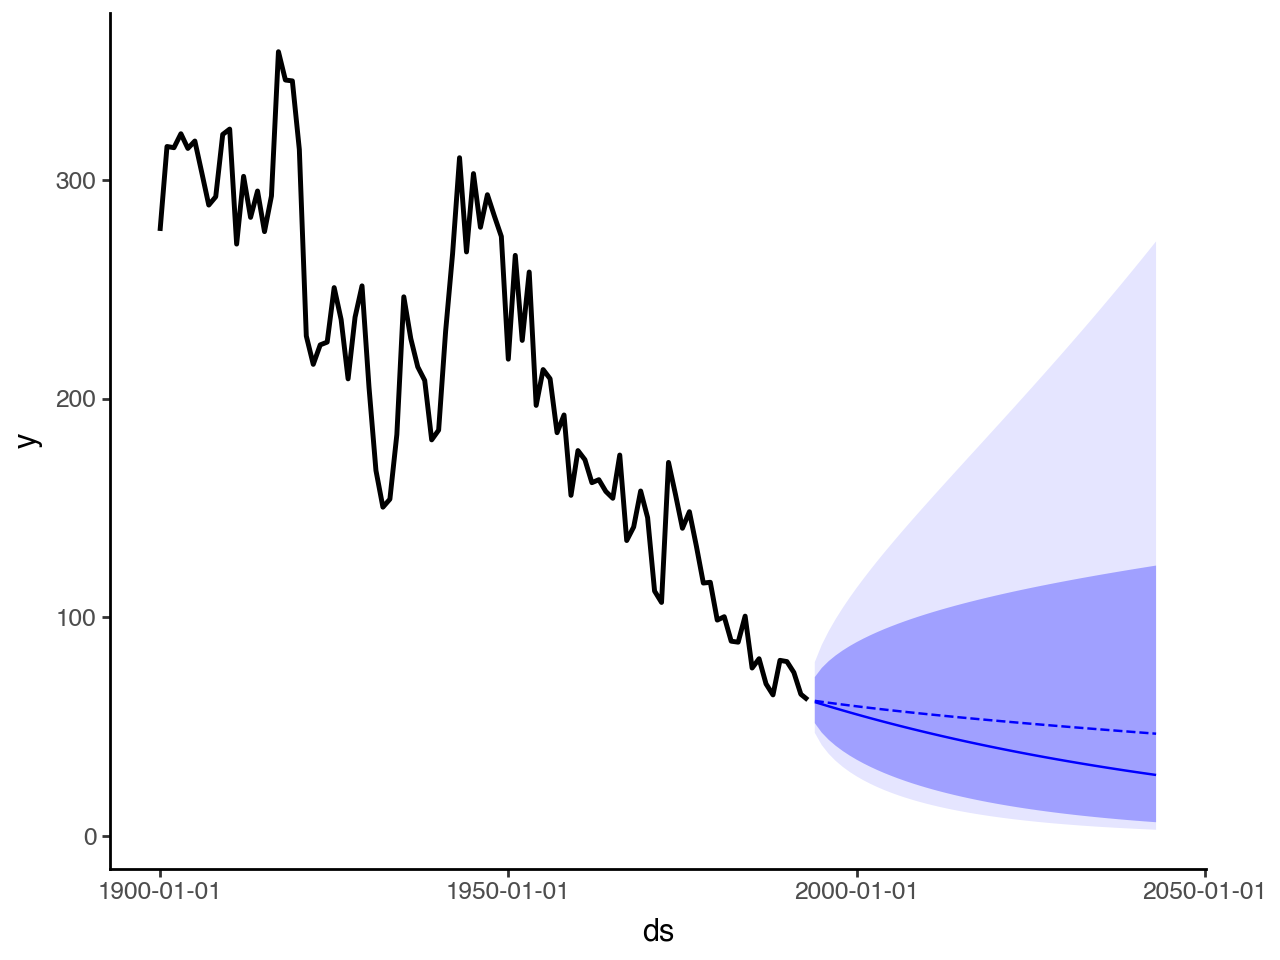

In [151]:
df_egg = pd.read_csv("data/raw/eggs.csv", parse_dates=["ds"])
df_egg_log = df_egg.copy()
df_egg_log['y'] = np.log(df_egg_log['y'])

rwd_method = RandomWalkWithDrift()
sf = StatsForecast(models=[rwd_method], freq="Y")
sf.fit(egg_df_log)
fcasts = sf.forecast(df=egg_df_log, h=50, level=[80, 95])
sigma_h = (fcasts['RWD-hi-80'] - fcasts['RWD-lo-80']) / (2 * 1.28)
sigma_h_squared = sigma_h**2
bias_adjusted = np.exp(fcasts['RWD']) * (1 + sigma_h_squared/2)
fcasts_original = fcasts.copy()
columns_to_transform = \
  ['RWD', 'RWD-lo-80', 'RWD-lo-95', 'RWD-hi-80', 'RWD-hi-95']
for col in columns_to_transform:
    fcasts_original[col] = np.exp(fcasts[col])
fcasts_original['RWD-adjusted'] = bias_adjusted

# filter on dates greater than last observed date
date_last_obs = df_egg['ds'].max()
df_fcast_new = fcasts_original.loc[fcasts_original['ds'].ge(date_last_obs)]

(ggplot(data=df_egg, mapping=aes(x='ds', y='y')) + 
  geom_line(size=1) + 
  geom_line(inherit_aes=False, data=fcasts_original, 
           mapping=(aes(x='ds', y='RWD')), color='blue') + 
  geom_line(inherit_aes=False, data=fcasts_original, 
           mapping=(aes(x='ds', y='RWD-adjusted')), color='blue', linetype='dashed') + 
  geom_ribbon(inherit_aes=False, data=df_fcast_new, 
              mapping=aes(ymin='RWD-lo-95', ymax='RWD-hi-95', x='ds'), alpha=.1, fill='blue') + 
  geom_ribbon(inherit_aes=False, data=df_fcast_new, 
              mapping=aes(ymin='RWD-lo-80', ymax='RWD-hi-80', x='ds'), alpha=.3, fill='blue') +
  theme_classic())

## 5.7. Forecasting with decomposition 

Using an additive decomposition, each score can be decomposed into the sum of a seasonal component ($\hat{S}_t$) and a seasonal-adjusted component ($\hat{A}_t = \hat{T}_t + \hat{R}_t$). Each component is estimated separately and $S_t$ is assumed to be unchanging or changing very slowly. To this point, $S_t$ is often estimated using simple methods such as taking the previous occurrence of the value (i.e., seasonal naïve method). 

Any non-seasonal forecasting method can be used to estimate the seasonally-adjusted component ($\hat{A}_t$; e.g., drift method, Holt's method, non-seasonal ARIMA model). 

In [164]:
df_emp = pd.read_csv("data/raw/us_employment_formatted.csv", parse_dates=["ds"])

df_emp = df_emp.query("Title == 'Retail Trade' and ds.dt.year >= 1992")

df_train = df_emp.drop(["Title"], axis=1)

# run STL decomposition on monthly US retail employment data
# NOTE: trend_deg=7 means a polynomial function of order 7 is used to 
# estimate the trend-cycle component 
stl = STL(df_train["y"].values, period=12, robust=True, trend_deg=7)
res = stl.fit()

# create seasonal values and trend-cycle value 
df_train["seasonal"] = res.seasonal
df_train["y_adjusted"] = df_train["y"] - df_train["seasonal"]

# predict trend-cycle component using naive method 
naive_method = Naive()
sf = StatsForecast(models=[naive_method], freq="M")

# create forecasts for 24 time periods into future 
adjusted_fcasts = sf.forecast(h=24, level=[80, 95], df=df_train, 
                              target_col="y_adjusted", fitted=True)

# training data trend-cycle values + upper and lower boudns of prediction intervals 
adjusted_fcasts_fitted = sf.forecast_fitted_values()

/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
/opt/miniconda3/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
/opt/miniconda3/lib/python3.13/site-packages/fpppy/utils.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


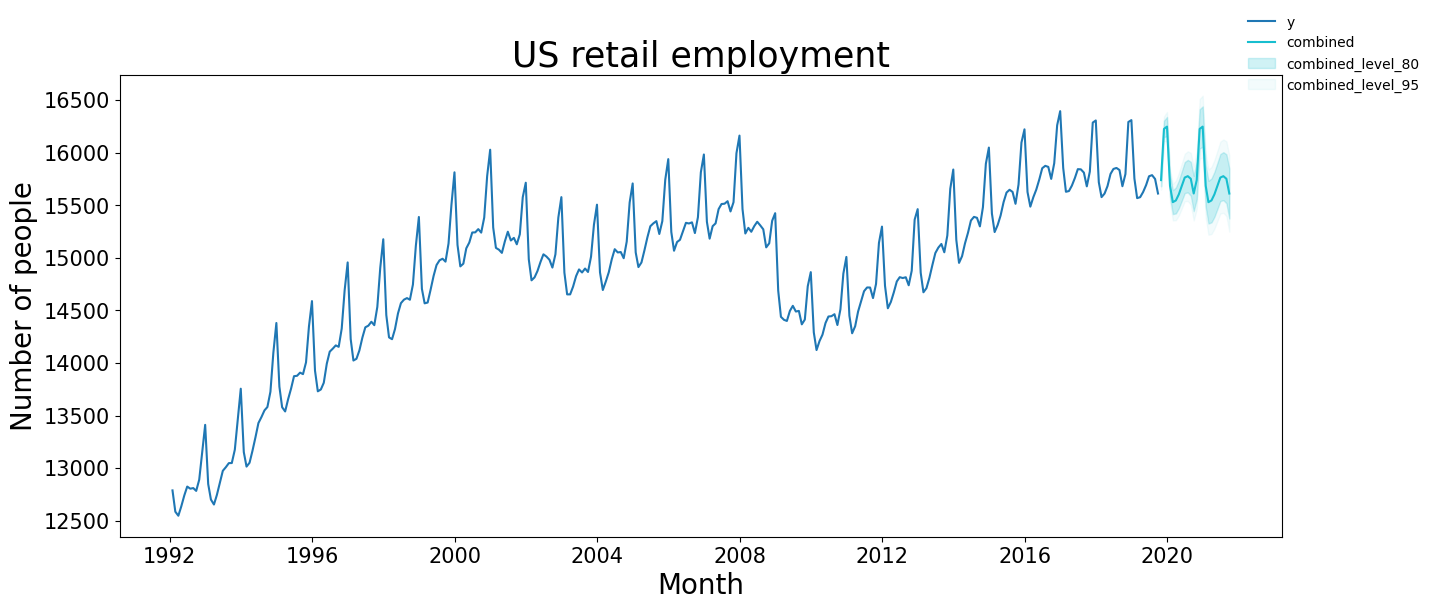

In [170]:
# create model of seasonal period + forecasts
seasonal_naive = SeasonalNaive(12)
sf = StatsForecast(models=[seasonal_naive], freq="M")
seasonal_fcasts = sf.forecast(h=24, level=[80, 95], df=df_train,
                              target_col="seasonal", fitted=True)

# merge trend-cycle + seasonal forecasts
df_forecast = adjusted_fcasts.merge(seasonal_fcasts, on=['unique_id', 'ds'],
                                  how='inner')

# merge training data 
df_fitted = adjusted_fcasts_fitted.merge(sf.forecast_fitted_values(),
  on=['unique_id', 'ds'], how='inner')

df_fitted["combined"] = df_fitted['Naive'] + df_fitted['SeasonalNaive']

df_fitted = df_fitted.merge(df_train, on=["unique_id", "ds"],how="right")


df_final = df_forecast[['unique_id', 'ds']].copy()  # Start with identifiers

df_final['combined'] = df_forecast['Naive'] + df_forecast['SeasonalNaive']

df_train["resid"] = (df_fitted["y"].values - 
                     df_fitted["Naive"].values - 
                     df_fitted["SeasonalNaive"].values)


df_final['combined-lo-80'] = df_forecast['Naive-lo-80'] + df_forecast['SeasonalNaive-lo-80']
df_final['combined-lo-95'] = df_forecast['Naive-lo-95'] + df_forecast['SeasonalNaive-lo-95']
df_final['combined-hi-80'] = df_forecast['Naive-hi-80'] + df_forecast['SeasonalNaive-hi-80']
df_final['combined-hi-95'] = df_forecast['Naive-hi-95'] + df_forecast['SeasonalNaive-hi-95']

plot_series(df_train, df_final, target_col="y", level=[80, 95],
            xlabel="Month",
            ylabel="Number of people",
            title="US retail employment",
            rm_legend=False)

## 5.8. Evaluating point forecast accuracy 

Keep a hold-out set of data to obtain an accurate estimate of forecasting performance. The test data should contain at least as many time points (in the future) as the forecasting horizon. 

Forecast errors represent residuals on future data (i.e., on the test set) and differ from residuals in that they can be based on multi-step forecasts (h>1; residuals are always based on one-step forecasts). 

$$
\epsilon_{T+h} = y_{T+h} - \hat{y}_{T+h|T}
$$

Three general categories of forecasting errors:

1. **Scale-dependent errors**: errors are on same scale as data. Useful by itself, but not possible to make predictions with models using different scales. Two common examples: 

$$
\text{Mean absolute error}: MAE = mean(|\epsilon_t|) \\
\text{Root mean squared error: RMSE} = \sqrt{mean(\epsilon^2_t)}
$$

As an side, minimizing the MAE leads to forecasts of the median and minimizing the RMSE leads to forecasts of the mean. 

2. **Percentage error**: unit-free ($p_t = 100 \frac{e_t}{y_t}$, but can become infinite and undefined. Moreover, extreme values occur when the observed value is close to 0. Related to this, percentage errors assume a meaningful zero, which is not always the case (e.g., temperature). Although sMAPE was created to address shortcomings of percentage errors, authors recommend not using because even this is severely limited. 

3. **Scaled errors**: proposed by Hyndman & Koehler (2006) and likely the best option as 
